In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import time
import matplotlib.pyplot as plt

import numpy as np

import cocaim
from cocaim import denoise
from cocaim.plots import util_plot

In [2]:
from skimage import io
mov = io.imread('../example_movies/demoMovie.tif').transpose([1,2,0])#[:,:60,:]
print(mov.shape)

(60, 80, 2000)


### Temporal denoiser

The video can be denoised temporally through block PCA. We begin by subtracting the mean and normalizing each pixel by the noise variance. The video is partitioned in tiles (~ soma size). PCA is applied to each tile to extract spatial and temporal components. The temporal components with Gaussian like autocorrelation are rejected. When the SNR is low, some block artifacts can be present. To compensate for this, we run this approach 3x more using 1/2 off grids (row-,column-, and row&column- wise) of the original block partitions. The then average these results to obtain a single denoised movie.

In [3]:
nblocks=[5,5]

In [4]:
mov_mean  = mov.mean(2,keepdims=True)
mov = mov - mov_mean
noise_level = denoise.noise_level(mov, range_ff=[0.25,0.5])
mov = mov/noise_level[:,:,np.newaxis]

Partition the movie in tiles smaller than the avg soma size.

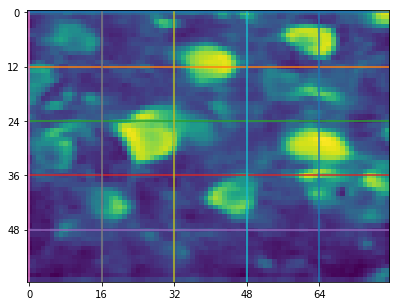

In [5]:
Cn1,_ = util_plot.correlation_pnr(mov)
util_plot.tiling_grid_plot(Cn1,
                           nblocks=nblocks,
                           plot_option='same')

Set dx to either {1,4} (number of denoisers) depending on SNR.<br/>
We begin by running the denoiser as vanilla PCA (greedy= False).<br/>
See function comments for detailed descriptions.<br/>

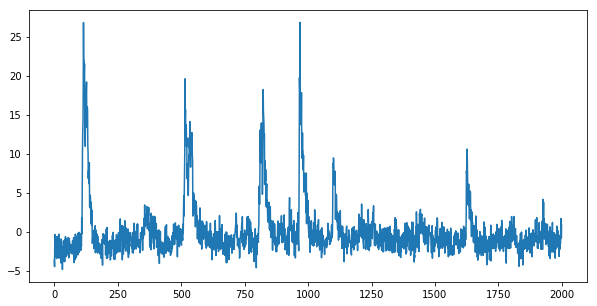

In [6]:
plt.figure(figsize=(10,5))
plt.plot(mov[25,25,:])

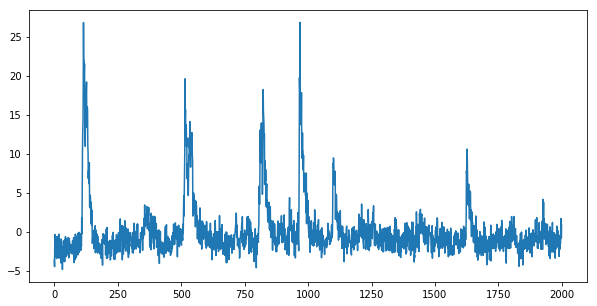

In [7]:
plt.figure(figsize=(10,5))
plt.plot(mov[25,25,:])

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
mov = mov.copy(order='C').astype('float64')

In [10]:
mov_denoised,ranks = denoise.temporal_reconstructed(mov,
                               nblocks=nblocks,
                               greedy= True,
                               dx=4)

Running 25 blocks in 22 cpus
Blocks(=25) run time: 3.805743
Running 20 blocks in 22 cpus
Blocks(=20) run time: 3.558274
Running 20 blocks in 22 cpus
Blocks(=20) run time: 3.311473
Running 16 blocks in 22 cpus
Blocks(=16) run time: 3.121141


Local correlation:  range [2.5e-02 9.5e-01]
Local correlation:  range [3.9e-01 1.0e+00]
Local correlation:  range [-8.0e-02 2.0e-01]


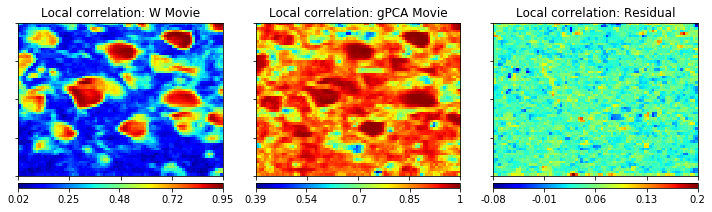

In [11]:
util_plot.comparison_plot([mov, mov_denoised],
                          option='corr',
                          titles_=['W Movie', 'gPCA Movie'],
                          plot_orientation='vertical',
                          cbar_orientation='horizontal',
                          remove_small_val=True
                         )

Visualize rank of each tile

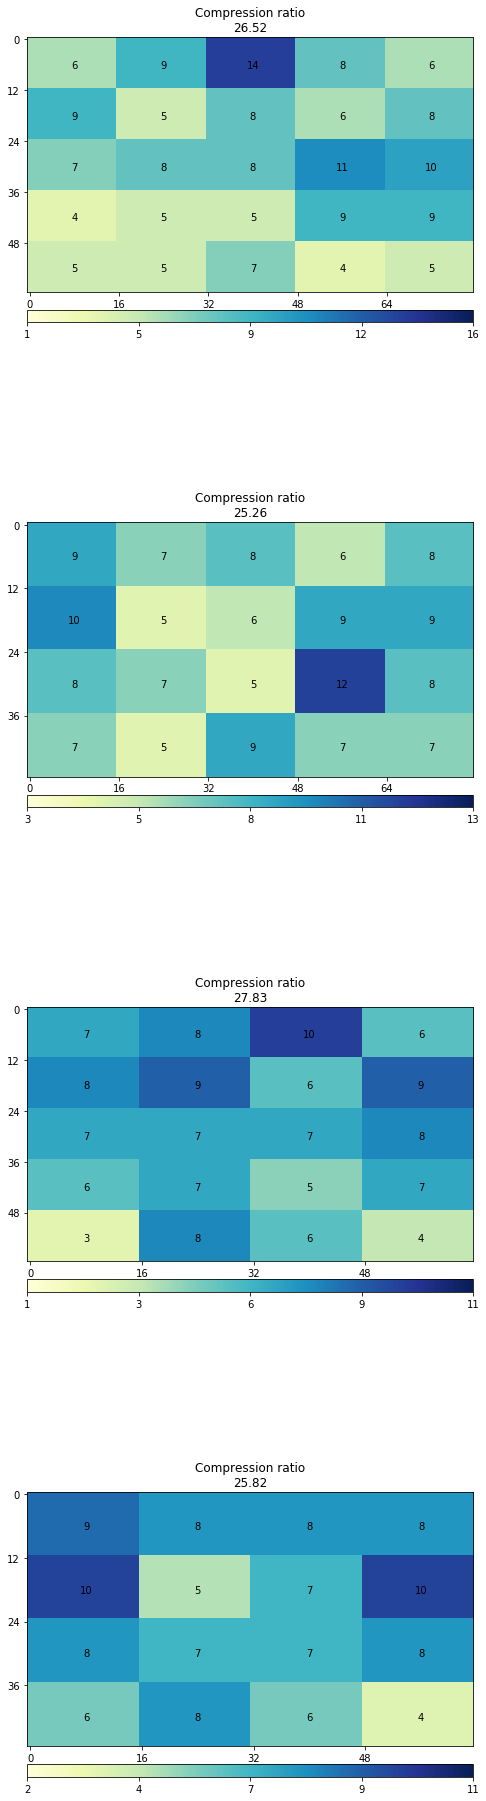

In [12]:
dims =mov.shape
_ = util_plot.cn_ranks_dx_plot(ranks,
                           dims,
                           nblocks=nblocks,
                           figsize=8,
                           fontsize=10)